# Final Project

## Exploratory data analysis of the Canadian cheese datasets

Author: Xuan Hong (Eyre)

# Introduction
<hr>

## 1. Question(s) of interests
In this analysis, I will be investigating a question associated with Canadian cheese. I am interested in finding the `fat level` of cheese. It is interesting because the obesity problem is getting more and more serious 21st century. According to [Statistics Canada](https://www150.statcan.gc.ca/n1/pub/82-625-x/2019001/article/00005-eng.htm), the Canadian obesity rate is 26.8%, and the overweight rate is 36.3% in 2018. 

![](img/overweight.png)

The rate was increased by 1.2%(around 270,000) since 2015. This shows the overweight problem is getting worse. 
Cheese is a common food and contains lots of fat. We should produce lower-fat cheese to decrease the potential fat that people will consume in daily life. We will build a model using the different features of the cheese to identify its fat level.

I will set the `lower fat` as the positive label since our preference is producing healthy cheese.


## 2. Import the libraries


In [1]:
# Import libraries needed for this lab
from hashlib import sha1

import altair as alt
import graphviz
import numpy as np
import pandas as pd
import string
import scipy
import matplotlib
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.svm import SVC, SVR
from scipy.stats import lognorm, loguniform, randint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Exploratory Data Analysis
<hr>

## I. Dataset description 

The below descriptions were taken directly from the [website](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b) where the datasets were obtained.

"A comprehensive database dedicated solely to Canadian cheeses made from cow, goat, sheep, or buffalo milk.
Canada produces more than 1450 cheeses that are listed in the Canadian Cheese Directory. The several varieties of cheese have been established according to guidelines including the type of milk, the cheese category, the milk treatment, the fat content, the ripening period and the production method."


The original cheese dataset is `canadianCheeseDirectory.csv`. It has been done a bit of wrangling and cleaning by UBC Data Science Instructors. The modified version is `cheese_data.csv`, let's import it.

In [2]:
# import the required file
cheese = pd.read_csv("data/cheese_data.csv")
cheese.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


Let's see what the tables look like.

In [3]:
cheese.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


Below is the informative description of the dataset.
* **cheese_data.csv** has 13 columns and 1041 rows.
    * CheeseId, `Numerical`, the ID of every cheese
    * ManufacturerProvCode, `Categorical`, the Canadian province that produces the cheese
    * ManufacturingTypeEn, `Categorical`, the Manufacturing type of cheese
    * MoisturePercent, `Numerical`, the moisture percentage of cheese
    * FlavourEn, `Text`, the flavour of the cheese
    * CharacteristicsEn, `Text`, the characteristics of cheese
    * Organic, `Numerical`, 1 means organic, 0 means non-organic
    * CategoryTypeEn, `Categorical`, the type of cheese
    * MilkTypeEn, `Categorical`, the milk type of cheese
    * MilkTreatmentTypeEn, `Categorical`, the milk treatment of cheese
    * RindTypeEn, `Categorical`, the rind type of cheese
    * CheeseName, `Text`, the name of the cheese
    * FatLevel, `Categorical`, the fat level of cheese

Let's do some visualization of the cheese data before building the model. First, we will like to see the number of the different fat level cheese.

In [4]:
# Use altair to generate a bar plot
fat_count_plot = (
    alt.Chart(cheese, width=500, height=300)
    .mark_bar(size=50)
    .encode(
        x=alt.X("FatLevel:N", title="Cheese Fat Level"),
        y=alt.Y("count():Q", title="Number"),
    )
    .properties(title="The number of different fat level cheese")
)
fat_count_plot

alt.Chart(...)

The lower fat level cheese is more than the higher fat level cheese. This surprises me because I think people prefer the higher fat level cheese and the manufactures will follow the customers' preferences.

I am also very interested in which type of milk makes the most lower fat level cheese. Which milk has a higher percentage of making lower-level fat cheese? We can groupby the `MilkTypeEn` and `FatLevel`, count the number of `FatLevel` and plot the graph.

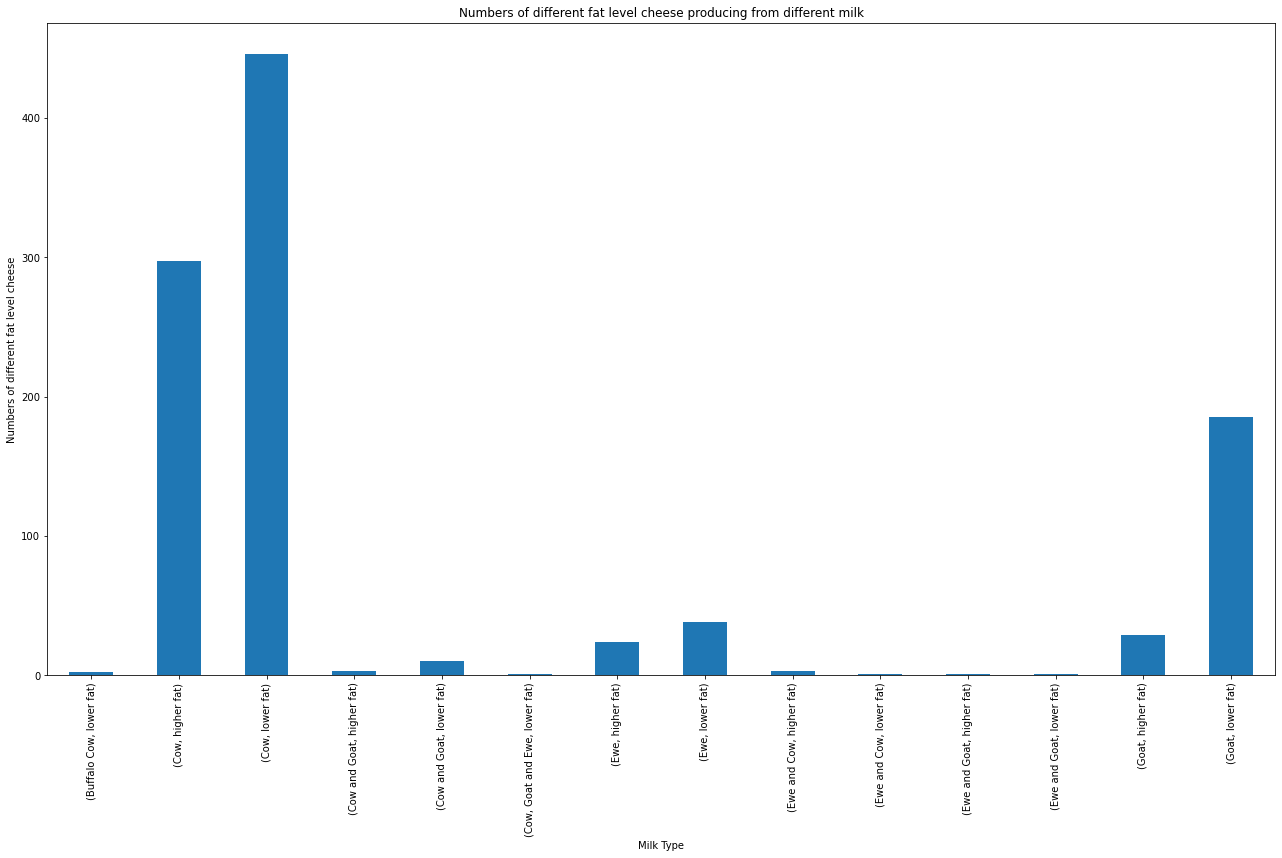

In [5]:
milk_fat_plot = cheese.groupby(['MilkTypeEn','FatLevel'])['FatLevel'].count()
milk_fat_plot.plot(kind='bar', figsize=(22,12))
plt.title('Numbers of different fat level cheese producing from different milk')
plt.xlabel('Milk Type')
plt.ylabel('Numbers of different fat level cheese')
plt.show()

The graph shows cow milk is the most common milk used to produce cheese. Although cow milk produces lower-fat cheese, it also produces a lot of higher-fat cheese. The interesting fact is that Goat milk has a high percentage of producing lower-fat cheese.

Before we do the analysis, we need to drop the **CheeseId** and **RindTypeEn** since these two columns do not relevant to our study. I will also drop the three Text type columns since they are making the test too complicated. 

In [6]:
cheese = cheese.drop(columns=['CheeseId', 'RindTypeEn', 'FlavourEn', 'CharacteristicsEn', 'CheeseName'])

## II. Split & Describe Train/Test Data 


We will set **FatLevel** as our target, and `lower Fat` as our positive label since we are interested to find healthy cheese. To avoid violating the golden rule, before we do anything with the data, let's split the data into `train_df` (80%) and `test_df` (20%). 

In [7]:
train_df, test_df = train_test_split(cheese, test_size=0.2, random_state=123)

Let's check which columns have the null values before we get the descriptive information.

In [8]:
train_df.isna().sum()

ManufacturerProvCode     0
ManufacturingTypeEn      0
MoisturePercent         12
Organic                  0
CategoryTypeEn          20
MilkTypeEn               1
MilkTreatmentTypeEn     52
FatLevel                 0
dtype: int64

We have $3$ columns with the null values. We can use imputation to deal with the null values in the analysis.

Now, let's use `.describe()` to show summary statistics of the $2$ numerical features **MoisturePercent** and **Organic** in the `train_df_nan` dataframe.

In [9]:
train_stats = train_df.describe()
train_stats

,MoisturePercent,Organic
count,821.000000,833.000000
mean,47.052741,0.091236
std,9.660351,0.288118
min,12.000000,0.000000
25%,40.000000,0.000000
50%,46.000000,0.000000
75%,52.000000,0.000000
max,92.000000,1.000000


The average moisture percentage of all the cheeses is $47$%, the highest moisture percentage is $92$%, and the lowest is $12$%. Since organic is a binary column, so the counting $833$ cheeses are organic, and $1042-833=209$ cheeses are non-organic.

Now, we are going to separate feature vectors from the targets.

In [10]:
X_train = train_df.drop(columns='FatLevel')
y_train = train_df['FatLevel']

X_test = test_df.drop(columns='FatLevel')
y_test = test_df['FatLevel']

X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized


# Methods and Results
<hr>

We will mainly use the `Radom Forest Classification` and `Logistic Regression Claddification` in this analysis since the target is a categorical column. I did some research and find that [Random Forest Method](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2264-5) has grown to a standard classification and normally yield improved accuracy compares to other classification methods when dealing with complicated features. I expect Random Forres Classifier will do a better job than the Logistic Regression Classification. I will also make imbalanced and balanced Random Forest Classification to do the analysis. I expect the balanced Random Forest Classification will perform the best result. After finding the best model, I will use RandomSearchCV to find the best $2$ hyperparameters and score them.

* I will list the steps of the analysis below:
    * Do the **preprocessing** to divide the different columns into different features sets.
    * Set the **f1, recall, precision, and accuracy** as our scoring method. **f1** is our main scoring method.
    * Build the **Logistic Regression Classifier** and get the mean scores.
    * Build the **Random Forest Classifier** with unbalanced weight and get the mean scores.
    * Build the **Random Forest Classifier** with balanced weight and get the mean scores.
    * Compare the scores and select the best model.
    * Use **RandomizedSearchCV** to find the best $2$ hyperparameters in the best model.
    * **Score** the best performing model.
    * Do the **confusion matrix** and **classification report**

## I. Preprocessing 

Let's do the preprocessing first. Divide the columns into different features.

In [11]:
numeric_features = ['MoisturePercent','Organic'] 
categorical_features = ['ManufacturerProvCode','ManufacturingTypeEn','CategoryTypeEn','MilkTypeEn','MilkTreatmentTypeEn'] 

Make the pipeline for the categorical features and numerical features.

In [12]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler())

In [13]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

Make a column transformer for the different features.

In [14]:
preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
)

Set the f1, recall, precision, and accuracy as our scoring method.

In [15]:
f1_scorer = make_scorer(f1_score, pos_label="lower fat")
precision_scorer = make_scorer(precision_score, pos_label="lower fat")
recall_scorer = make_scorer(recall_score, pos_label="lower fat")
accuracy_scorer = make_scorer(accuracy_score)

scoring={"accuracy": accuracy_scorer,
         "f1": f1_scorer,
         "recall": recall_scorer,
         "precision": precision_scorer,
}

## II. Model Building

### 1. Logistic Regression Classification

Build the Logistic Regression Classification model and score it.

In [16]:
lr_pipe = make_pipeline(preprocessor,
                                LogisticRegression(random_state=123))

lr_pipe.fit(X_train, y_train)
lr_scores = pd.DataFrame(cross_validate(lr_pipe,
                                        X_train,
                                        y_train,
                                        n_jobs=-1,
                                        cv=5,
                                        scoring=scoring,
                                        return_train_score=True))
lr_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.036449,0.014248,0.784431,0.788288,0.842105,0.843507,0.872727,0.867580,0.813559,0.820734
1,0.038091,0.013499,0.808383,0.801802,0.858407,0.853007,0.881818,0.874429,0.836207,0.832609
2,0.039666,0.013453,0.736527,0.812312,0.798165,0.861573,0.790909,0.888128,0.805556,0.836559
3,0.040521,0.013351,0.789157,0.800600,0.840183,0.852713,0.844037,0.876993,0.836364,0.829741
4,0.036289,0.013396,0.771084,0.802099,0.827273,0.853659,0.834862,0.876993,0.819820,0.831533


Find the mean scores of the Logistic Regression Classification.

In [17]:
lr_mean = lr_scores.mean()
lr_mean

fit_time           0.038203
score_time         0.013589
test_accuracy      0.777916
train_accuracy     0.801020
test_f1            0.833227
train_f1           0.852892
test_recall        0.844871
train_recall       0.876825
test_precision     0.822301
train_precision    0.830235
dtype: float64

The mean f1 train score of Logistic Regression Classification is $0.8529$ and the mean f1 test score is $0.8332$. 

### 2. Random Forest Classification

### a) Unbalanced Random Forest Classification

Build the unbalanced Random Forest Classification and fit it.

In [18]:
unbalanced_pipe = make_pipeline(preprocessor,
                                RandomForestClassifier(random_state=123,
                                                       class_weight=None))
unbalanced_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent',
                                                   'Organic']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                

Get the score of unbalanced Random Forest Classification.

In [19]:
rf_unbalanced_scores = pd.DataFrame(cross_validate(unbalanced_pipe,
                                                   X_train,
                                                   y_train,
                                                   cv=5,
                                                   scoring=scoring,
                                                   return_train_score=True)) 
rf_unbalanced_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.264829,0.028202,0.832335,0.951952,0.867925,0.963387,0.836364,0.961187,0.901961,0.965596
1,0.265702,0.027968,0.808383,0.951952,0.851852,0.963218,0.836364,0.956621,0.867925,0.969907
2,0.252206,0.028094,0.808383,0.947447,0.853211,0.960091,0.845455,0.961187,0.861111,0.958998
3,0.259170,0.027767,0.837349,0.943028,0.875576,0.956322,0.871560,0.947608,0.879630,0.965197
4,0.256334,0.027861,0.813253,0.946027,0.855814,0.958716,0.844037,0.952164,0.867925,0.965358


Get the mean score of unbalanced Random Forest Classification.

In [20]:
rf_unbalanced_mean = rf_unbalanced_scores.mean()
rf_unbalanced_mean

fit_time           0.259648
score_time         0.027978
test_accuracy      0.819941
train_accuracy     0.948081
test_f1            0.860875
train_f1           0.960347
test_recall        0.846756
train_recall       0.955754
test_precision     0.875710
train_precision    0.965011
dtype: float64

The mean f1 train score of unbalanced Random Forest Classification is $0.9603$, and the mean f1 test score is $0.8609$. They are higher than the Logistic Regression Classification. Other than the f1 score, the accuracy, recall, and precision are all higher than the Logistic Regression Classification. In this way, we will choose the Random Forest Classification rather than the Logistic Regression Classification. However, we will still check whether the balanced data or imbalanced data in Random Forest Classification will show a better result.

### b) Balanced Random Forest Classification

Build the balanced Random Forest Classification and fit it.

In [21]:
balanced_pipe = make_pipeline(preprocessor,
                              RandomForestClassifier(random_state=123,
                                                     class_weight="balanced"))
balanced_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent',
                                                   'Organic']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                

Get the score of balanced Random Forest Classification.

In [22]:
rf_balanced_scores = pd.DataFrame(cross_validate(balanced_pipe,
                                                 X_train,
                                                 y_train,
                                                 cv=5,
                                                 scoring=scoring,
                                                 return_train_score=True)) 
rf_balanced_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.272324,0.028029,0.808383,0.951952,0.849057,0.963134,0.818182,0.954338,0.882353,0.972093
1,0.259175,0.027982,0.820359,0.951952,0.859813,0.962791,0.836364,0.945205,0.884615,0.981043
2,0.256268,0.028229,0.832335,0.947447,0.871560,0.959538,0.863636,0.947489,0.879630,0.971897
3,0.271864,0.028921,0.843373,0.943028,0.880734,0.955814,0.880734,0.936219,0.880734,0.976247
4,0.262684,0.028727,0.807229,0.946027,0.847619,0.958237,0.816514,0.940774,0.881188,0.976359


Get the mean score of balanced Random Forest Classification.

In [23]:
rf_balanced_mean = rf_balanced_scores.mean()
rf_balanced_mean

fit_time           0.264463
score_time         0.028378
test_accuracy      0.822336
train_accuracy     0.948081
test_f1            0.861756
train_f1           0.959903
test_recall        0.843086
train_recall       0.944805
test_precision     0.881704
train_precision    0.975528
dtype: float64

The mean f1 train score of balanced Random Forest Classification is $0.9599$, and the mean f1 test score is $0.8618$. The test score is higher than the unbalanced one though the training score is lower than it. We will choose the **balanced** one in this case.

### 3. Find the best hyperparameters

Build the model to find the best `n_estimators` and `max_depth` in the Random Forest Classification.

In [24]:
rf_pipeline = make_pipeline(preprocessor,
                              RandomForestClassifier(random_state=123,
                                                     class_weight="balanced"))


param_dist = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20),
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit=scoring,
    random_state=123
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=108; total time=   0.3s
[CV] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=108; total time=   0.3s
[CV] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=108; total time=   0.3s
[CV] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=108; total time=   0.3s
[CV] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=108; total time=   0.3s
[CV] END randomforestclassifier__max_depth=8, randomforestclassifier__n_estimators=27; total time=   0.1s
[CV] END randomforestclassifier__max_depth=8, randomforestclassifier__n_estimators=27; total time=   0.1s
[CV] END randomforestclassifier__max_depth=8, randomforestclassifier__n_estimators=27; total time=   0.1s
[CV] END randomforestclassifier__max_depth=8, randomforestclassifier__n_estimato

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent',
                                                                                'Organic']),
                                                                              ('pipeline-2',
                                                       

Use `best_params_` and `best_score_` to find the best hyperparameter value and the corresponding validation score.

In [25]:
best_parameters = random_search.best_params_
best_score = random_search.best_score_

print(best_parameters,best_score)

{'randomforestclassifier__max_depth': 9, 'randomforestclassifier__n_estimators': 139} 0.8343842435610707


The best hyperparameter of `max_depth` is $9$ and `n_estimators` is $139$. The validation score is $0.8344$. 
Let's finally find the train and test score of the best scoring model.

In [26]:
train_score = random_search.score(X_train, y_train)
test_score = random_search.score(X_test, y_test)

print(train_score, test_score)

0.9135654261704682 0.8373205741626795


The best train score is $0.9136$, and the best test score is $0.8373$.

Now, let's plot a confusion matrix on the test set and do some analysis.

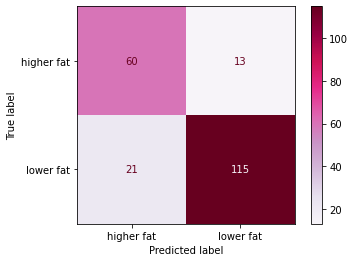

In [27]:
cm_plot = plot_confusion_matrix(random_search,
                                X_test,
                                y_test,
                                display_labels=["higher fat", "lower fat"],
                                values_format="d",
                                cmap="PuRd");
cm_plot

The TP(True Positive) is $115$, the FP(False Positive) is $13$, the TN(True Negative) is $60$, and the FN(False Negative) is $21$.

Let's print the classification report on the `X_test` predictions of `random_search`'s best model.

In [28]:
predicted_y = random_search.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4))

              precision    recall  f1-score   support

  higher fat     0.7407    0.8219    0.7792        73
   lower fat     0.8984    0.8456    0.8712       136

    accuracy                         0.8373       209
   macro avg     0.8196    0.8338    0.8252       209
weighted avg     0.8434    0.8373    0.8391       209



The f1 of the positve label(lower fat) is $0.8712$, the weighted avg of f1 is $0.8391$.

# Discussion
<hr>

In this project, I analyzed the Canadian dataset and tried to find the best model to identify the healthy cheese, which means its fat level is lower fat. I use $2$ methods, Random Forest Classification and Logistic Regression Classification, to build the model and use the f1 score to be the main scoring method. In addition, I make $2$ different Random Forest Classification models based on the data weight balanced. One is unbalanced Random Forest Classification and one is balanced Random Forest Classification. I expect the balanced Random Forest Classification to perform a better result based on the study's result. After finding the best model, I use RandomSearchCV to find the best $2$ hyperparameters and do the final scoring.

* Below is the f1 score result of the $3$ different models:
  *  The mean f1 train score of Logistic Regression Classification is $0.8529$ and the mean f1 test score is $0.8332$. 
  * The mean f1 train score of unbalanced Random Forest Classification is $0.9603$ and the mean f1 test score is $0.8609$.
  * The mean f1 train score of balanced Random Forest Classification is $0.9599$ and the mean f1 test score is $0.8618$.

In our test, the score of Random Forest Classification is all higher than the Logistic Regression Classification. Also, the balanced model has a higher f1, accuracy and precision score, only the recall score ($0.8431$) is slightly lower than the unbalanced one ($0.8468$). We can conclude that the balanced model should be the best model. 

Based on the f1 scores, I select the balanced Random Forest Classification to be the best model. To get the best result, I use RandomSearchCV to find the best hyperparameters of Random Forest Classification. the best hyperparameter of `max_depth` is $9$ and `n_estimators` is $139$, and the `validation score` is $0.8344$. We use this best model to do the scoring. The best `train accuracy score` is $0.9136$, and the best `test accuracy score` is $0.8373$. I plot the confusion matrix and print the classification report. It shows the best f1 score is $0.8712$, which is the highest one we got in all these models. 

The result is the same as my expectation. Balanced Random Forest Classification is the best model to do the cheese classification. The model I did is not a perfect one because it does not contain the Text type columns `FlavourEn`, `CharacteristicsEn`, and `CheeseName`. These three features will also help to identify the fat level of the cheese and elect a healthy one. 

The other question I am interested in is maybe we can use `FlavourEn` and `fat level` to see which words are related to the different fat level cheese most. Will customers have a different review for lower fat cheese and higher fat cheese? It is interesting because we can use it to adjust the flavour of lower-fat cheese. This might encourage people who like the flavour of higher fat level cheese more likely to change to select lower fat level cheese. It will help reduce the overweight problem.

# References
<hr>

* [Data Source](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b)
    * This Canadian Cheese database used in this work was created by **Canadian Dairy Information Centre (CDIC)**.
* [Question Of Interest](https://www150.statcan.gc.ca/n1/pub/82-625-x/2019001/article/00005-eng.htm)
    * Inspiration for the overweight and obese adults, 2018 created by **Statistics Canada**.
* [Methods](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2264-5)
    * Inspiration for this studies to compare that Radom Forest Classification and Logistic Regression Classification